# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from microParser import micro2Py

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scanRandom.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [4]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0
dataDF['excludedRelic'] = dataDF['Omega'] > 0.13
#Xenon 1T curve (from micromegas):
data_1t_lnM = [1.790E+00, 1.885E+00, 2.006E+00, 2.148E+00, 2.297E+00, 2.449E+00, 2.598E+00, 2.783E+00, 2.961E+00, 3.117E+00, 3.302E+00, 3.444E+00, 3.614E+00, 3.796E+00, 4.037E+00, 4.268E+00, 4.581E+00, 4.904E+00, 5.178E+00, 5.441E+00, 5.768E+00, 6.095E+00, 6.369E+00, 6.550E+00, 6.891E+00]
data_1t_lnS = [1.040E+00, 2.794E-02,-1.003E+00,-2.035E+00,-2.888E+00,-3.591E+00,-4.144E+00,-4.717E+00,-5.111E+00,-5.326E+00,-5.458E+00,-5.486E+00,-5.440E+00,-5.375E+00,-5.178E+00,-4.982E+00,-4.711E+00,-4.412E+00,-4.150E+00,-3.925E+00,-3.598E+00,-3.270E+00,-3.009E+00,-2.812E+00,-2.485E+00]
xenonF = interp1d(data_1t_lnM,data_1t_lnS,
                  bounds_error=False,fill_value="extrapolate") #interpolate in log
@np.vectorize
def xenonUL(mDM):
    return 1e-8*np.exp(xenonF(np.log(mDM))) #90% upper limit on sigmaNucleon (pb)

rDD = (dataDF['Omega']/0.12)*(dataDF['proton_SI']+dataDF['neutron_SI'])/2.0
rDD = rDD/xenonUL(dataDF['mass.1000022'])
dataDF['excludedDD'] = (rDD > 1)

#### Add c*tau column for charginos

In [5]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]
excludedDM = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == True)]
excludedDD = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                    & (dataDF['excludedDD'] == True)]

allowed = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                 & (dataDF['excludedDD'] == False)]

print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total excluded (relic) = %i'%(len(excludedDM)))
print('Total excluded (DD) = %i'%(len(excludedDD)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 96669
Total excluded (LHC) = 7348
Total excluded (relic) = 41245
Total excluded (DD) = 12347
Total allowed = 35729



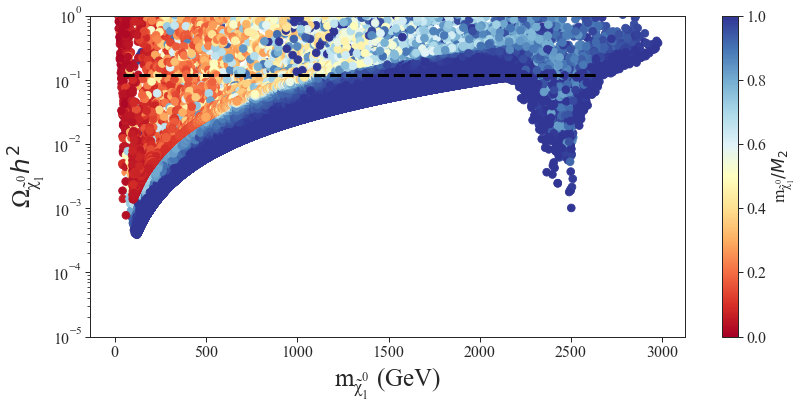

In [7]:

plt.figure(figsize=(12,6))

x = dataDF['mass.1000022']
y = dataDF['Omega']
z = dataDF['mass.1000022']/dataDF['extpar.2']
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(x,y,c=z,label='Excluded (DM)',s=60,cmap=cm,vmin=0,vmax=1)

        
plt.hlines(y=0.12,xmin=allowed['mass.1000022'].min(),xmax=allowed['mass.1000022'].max(),
           linewidth=3,linestyle='--',color='black')
plt.yscale('log')
plt.ylim(1e-5,1)
# plt.xlim(0,800)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{\Omega_{\tilde{\chi}_1^0}} h^2$',fontsize = 25)
plt.colorbar(label=r'$\mathregular{m_{\tilde{\chi}_1^0}}/M_2$')
plt.tight_layout()
plt.show()

In [8]:
lowOm = dataDF[(dataDF['Omega'] < 0.005) & (abs(dataDF['mass.1000022']-2500) < 10)]

In [9]:
lowOm[['extpar.1','extpar.2','extpar.23','extpar.25','mass.1000022','Omega','filename']]

,extpar.1,extpar.2,extpar.23,extpar.25,mass.1000022,Omega,filename
30946,2468.84409,2526.60097,2602.23575,6.609043,2504.74236,0.00214,ew_gfip2xrz.slha
30326,2481.17209,2433.22142,2535.87251,9.171424,2497.88802,0.00188,ew_ggj252kx.slha
2064,2809.13955,2478.06019,2486.28077,11.662551,2498.05546,0.00372,ew_f3o370k_.slha
11957,2474.32951,2544.19897,2559.84728,16.052599,2509.06397,0.00287,ew_lbtvxw5f.slha
60293,2457.89799,2535.52790,2579.74239,17.705142,2496.64774,0.00196,ew_eth8lcb_.slha
45274,2463.14572,2498.74700,2600.75706,10.154730,2501.00826,0.00101,ew_akk3lu0_.slha


In [10]:
import sys
sys.path.append('../EWino/')
from genSLHAfiles import runSoftSUSY
from runMicroMegas import runMicroMegas
from configParserWrapper import ConfigParserExt

In [50]:
parser = ConfigParserExt(inline_comment_prefixes=';')
ret = parser.read('../EWino/scanRandom_pars.ini')
parserDict = parser.toDict(raw=True)
parserDict.pop('conditions')
iloc = 45274
M1 = lowOm.loc[iloc]['extpar.1']
M2 = lowOm.loc[iloc]['extpar.2']
mu = lowOm.loc[iloc]['extpar.23']
tanb = lowOm.loc[iloc]['extpar.25']

pts = []

# for k in np.linspace(0.7,1.0,5):
for k in [1.0]:   
    M1v = k*M1
    M2v = k*M2
    muv = k*mu
# print('M1 = %1.3f, M2 = %1.3f, mu = %1.3f, tanb = %1.3f' %(M1,M2,mu,tanb))

    parserDict['extpar']['0'] = max([M1v,M2v,muv])
    parserDict['extpar']['1'] = M1v
    parserDict['extpar']['2'] = M2v
    parserDict['extpar']['23'] = muv
    parserDict['extpar']['25'] = tanb
    parserDict['options']['outputFolder'] = './'
    parserDict['options']['outputFile'] = './test.slha'
    parserDict['options']['template'] = '../EWino/template_softsusy2.in'

    parserM = ConfigParserExt(inline_comment_prefixes=';')
    ret = parserM.read('../EWino/micromegas_pars.ini')
    parserDictM = parserM.toDict(raw=True)
    parserDictM['options']['outputFolder'] = './'
    parserDictM['options']['inputFile'] = parserDict['options']['outputFile']
    parserDictM['options']['doVirtualWZ'] = True

    #Run SoftSUSY
    r = runSoftSUSY(parserDict)
    #Run Micromegas
    r = runMicroMegas(parserDictM)
    microDict = micro2Py(parserDict['options']['outputFile'].replace('.slha','.micro'),
                        relicContributions=True)
    
    omega = microDict['Omega']
    channels = microDict['ChannelsRelic']
    
    pts.append([k,omega,channels])
    
    print(k,omega)
    for chan in channels:
        print(chan)

1.0 0.404
[0.39, '~o1 ~o1 ->W+ W-']
[0.07, '~1+ ~o1 ->u D']
[0.07, '~1+ ~o1 ->S c']
[0.06, '~1+ ~o1 ->t B']
[0.05, '~1+ ~o1 ->Z W+']
[0.04, '~o1 ~o1 ->t T']
[0.03, '~o1 ~o2 ->W+ W-']
[0.02, '~1+ ~o1 ->W+ h']
[0.02, '~1+ ~o1 ->nm M']
[0.02, '~1+ ~o1 ->ne E']
[0.02, '~1+ ~o1 ->nl L']
[0.01, '~1+ ~1+ ->W+ W+']
[0.01, '~1+ ~o1 ->A W+']
[0.01, '~1+ ~1- ->W+ W-']


<ipython-input-12-465b2303cb82>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pts = np.array(pts)


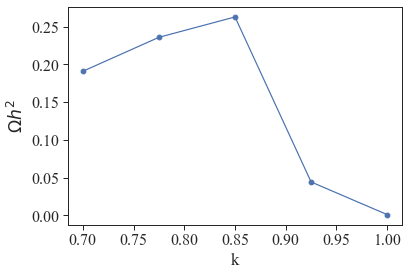

In [12]:
pts = np.array(pts)
plt.plot(pts[:,0],pts[:,1],'-o')
plt.xlabel('k')
plt.ylabel(r'$\Omega h^2$')
plt.show()

In [21]:
channelsDict = {}
for pt in pts:
    channels = pt[-1]
    channels = [x[1] for x in channels[:]]
    for x in channels: channelsDict[x] = []

In [22]:
for pt in pts:
    channels = pt[-1]
    for x in channelsDict:
        channelsDict[x].append(0.)
    for chan in channels:
        channelsDict[chan[1]][-1] = chan[0]

<ipython-input-45-c45fa09b8c2f>:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


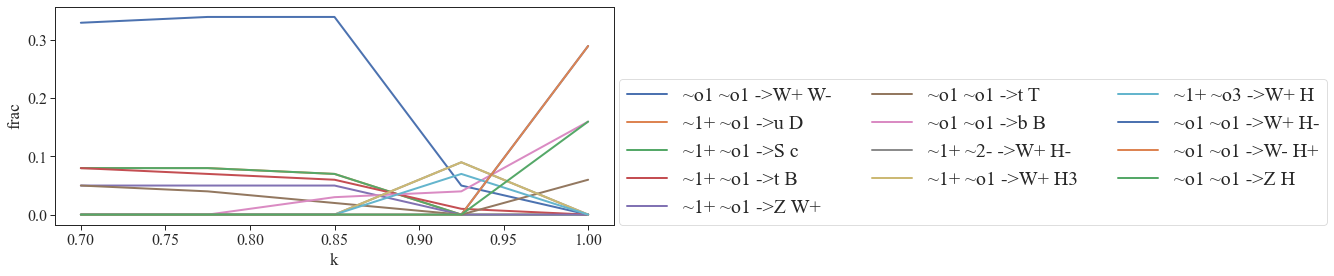

In [45]:
plt.figure(figsize=(10,4))
for chan in channelsDict:
    vals = channelsDict[chan]
    if max(vals) < 0.05: continue
    k = pts[:,0]
    plt.plot(k,vals,label=chan,linewidth=2)
plt.xlabel('k')    
plt.ylabel('frac')
plt.legend(ncol=3,loc=(1.01,0.),fontsize=20)
plt.tight_layout()
plt.show()